In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

---

## Evalutation of ADA

In [2]:
# Set style for all plots
sns.set_palette("deep")
sns.set_context("talk", font_scale=0.8)


def load_experiment_results(results_dir: str, num_runs: int) -> tuple[list, list]:
    """Load results from multiple experimental runs."""
    results_dir = Path(results_dir)
    challenger_metrics = []
    benchmark_metrics = []

    for run in range(num_runs):
        if run == 2:
            # Skip run 2
            continue
        try:
            # Load challenger results
            challenger_file = results_dir / \
                f"v3/da_challenger_v3_basin_metrics_{run}.csv"
            if challenger_file.exists():
                challenger_metrics.append(pd.read_csv(challenger_file))

            # Load benchmark results
            benchmark_file = results_dir / f"benchmark_basin_metrics_{run}.csv"
            if benchmark_file.exists():
                benchmark_metrics.append(pd.read_csv(benchmark_file))
        except Exception as e:
            print(f"Error loading run {run}: {str(e)}")
            continue

    return challenger_metrics, benchmark_metrics


def aggregate_metrics(metrics_list: list) -> pd.DataFrame:
    """Aggregate metrics across multiple runs."""
    if not metrics_list:
        raise ValueError("No metrics to aggregate")

    # Stack all runs and group by basin_id and horizon
    all_metrics = pd.concat([df.assign(run=i)
                            for i, df in enumerate(metrics_list)])

    # Calculate mean and std across runs
    agg_metrics = (
        all_metrics.groupby(["basin_id", "horizon"])
        .agg(
            {
                "NSE": ["mean", "std"],
                "MSE": ["mean", "std"],
                "MAE": ["mean", "std"],
                "RMSE": ["mean", "std"],
            }
        )
        .reset_index()
    )

    # Flatten column names
    agg_metrics.columns = [
        "_".join(col).strip("_") for col in agg_metrics.columns.values
    ]

    return agg_metrics


def calculate_performance_comparison(
    challenger_df: pd.DataFrame, benchmark_df: pd.DataFrame
) -> pd.DataFrame:
    """Calculate performance comparison between challenger and benchmark models."""
    # Get unique horizons
    horizons = sorted(challenger_df["horizon"].unique())

    results = {
        "horizon": [],
        "better": [],
        "insignificant": [],
        "worse": [],
        "mean_nse_diff": [],
        "std_nse_diff": [],
    }

    for horizon in horizons:
        challenger_horizon = challenger_df[challenger_df["horizon"] == horizon]
        benchmark_horizon = benchmark_df[benchmark_df["horizon"] == horizon]

        comparison = pd.merge(
            challenger_horizon,
            benchmark_horizon,
            on=["basin_id", "horizon"],
            suffixes=("_challenger", "_benchmark"),
        )

        total_basins = len(comparison)

        # Compare mean NSE values
        diff = comparison["NSE_mean_challenger"] - \
            comparison["NSE_mean_benchmark"]

        # Calculate statistical significance using std across runs
        combined_std = np.sqrt(
            comparison["NSE_std_challenger"] ** 2 +
            comparison["NSE_std_benchmark"] ** 2
        )
        significant_threshold = 1.96 * combined_std  # 95% confidence interval

        # Count significant differences
        challenger_wins = (diff > significant_threshold).sum()
        benchmark_wins = (diff < -significant_threshold).sum()
        insignificant = (abs(diff) <= significant_threshold).sum()

        results["horizon"].append(horizon)
        results["better"].append((challenger_wins / total_basins) * 100)
        results["insignificant"].append((insignificant / total_basins) * 100)
        results["worse"].append((benchmark_wins / total_basins) * 100)
        results["mean_nse_diff"].append(diff.mean())
        results["std_nse_diff"].append(diff.std())

    return pd.DataFrame(results)


def plot_performance_comparison(comparison_df: pd.DataFrame) -> None:
    """Create stacked bar plot of performance comparison."""
    pastel_green = "#6BA292"
    pastel_red = "#93827F"
    pastel_yellow = "#F9E79F"

    plt.figure(figsize=(12, 6))

    plt.bar(
        comparison_df["horizon"],
        comparison_df["better"],
        label="Challenger Significantly Better",
        color=pastel_green,
    )
    plt.bar(
        comparison_df["horizon"],
        comparison_df["insignificant"],
        bottom=comparison_df["better"],
        label="No Significant Difference",
        color=pastel_yellow,
    )
    plt.bar(
        comparison_df["horizon"],
        comparison_df["worse"],
        bottom=comparison_df["better"] + comparison_df["insignificant"],
        label="Benchmark Significantly Better",
        color=pastel_red,
    )

    plt.xlabel("Forecast Horizon (days)")
    plt.ylabel("Percentage of Basins")
    plt.title(
        "Model Performance Comparison by Horizon\nWith Statistical Significance")
    # Add the legend below the plot
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.ylim(0, 100)

    sns.despine()
    plt.yticks(np.arange(0, 101, 20), [f"{i}%" for i in range(0, 101, 20)])
    plt.xticks(comparison_df["horizon"])

    plt.tight_layout()
    plt.show()


def plot_nse_comparison(
    challenger_df: pd.DataFrame, benchmark_df: pd.DataFrame
) -> None:
    """Create bar plot comparing NSE scores between models."""
    # Calculate mean and confidence intervals for each horizon
    horizons = sorted(challenger_df["horizon"].unique())

    ch_means = [
        challenger_df[challenger_df["horizon"] == h]["NSE_mean"].mean()
        for h in horizons
    ]
    ch_stds = [
        challenger_df[challenger_df["horizon"] == h]["NSE_std"].mean() for h in horizons
    ]

    bm_means = [
        benchmark_df[benchmark_df["horizon"] == h]["NSE_mean"].mean() for h in horizons
    ]
    bm_stds = [
        benchmark_df[benchmark_df["horizon"] == h]["NSE_std"].mean() for h in horizons
    ]

    plt.figure(figsize=(15, 6))
    bar_width = 0.35
    x_pos = np.arange(len(horizons))

    colors = sns.color_palette("Blues", 2)

    # Plot bars with error bars
    plt.bar(
        x_pos - bar_width / 2,
        ch_means,
        bar_width,
        yerr=ch_stds,
        label="Challenger",
        color=colors[0],
        capsize=5,
        alpha=0.8,
    )
    plt.bar(
        x_pos + bar_width / 2,
        bm_means,
        bar_width,
        yerr=bm_stds,
        label="Benchmark",
        color=colors[1],
        capsize=5,
        alpha=0.8,
    )

    plt.xlabel("Forecast Horizon (days)")
    plt.ylabel("Nash-Sutcliffe Efficiency (NSE)")
    plt.title(
        "Model Performance Comparison by Horizon\nwith Standard Deviation across Runs"
    )
    plt.xticks(x_pos, horizons)
    plt.legend()
    sns.despine()

    # Add value labels
    for i, (ch, bm) in enumerate(zip(ch_means, bm_means)):
        plt.text(i - bar_width / 2, ch + 0.02, f"{ch:.2f}", ha="center")
        plt.text(i + bar_width / 2, bm + 0.02, f"{bm:.2f}", ha="center")

    plt.tight_layout()
    plt.show()


def print_summary_statistics(comparison_df: pd.DataFrame) -> None:
    """Print summary statistics of the performance comparison."""
    print("\nPerformance Summary:")
    print(
        f"Average percentage where challenger significantly outperforms: {comparison_df['better'].mean():.1f}%"
    )
    print(
        f"Average percentage with no significant difference: {comparison_df['insignificant'].mean():.1f}%"
    )
    print(
        f"Average percentage where benchmark significantly outperforms: {comparison_df['worse'].mean():.1f}%"
    )

    print(
        f"\nBest horizon for challenger: {comparison_df.loc[comparison_df['better'].idxmax(), 'horizon']} "
        f"({comparison_df['better'].max():.1f}%)"
    )
    print(
        f"Worst horizon for challenger: {comparison_df.loc[comparison_df['better'].idxmin(), 'horizon']} "
        f"({comparison_df['better'].min():.1f}%)"
    )

    mean_nse_improvement = comparison_df["mean_nse_diff"].mean()
    print(
        f"\nMean NSE improvement across all horizons: {mean_nse_improvement:.3f}")

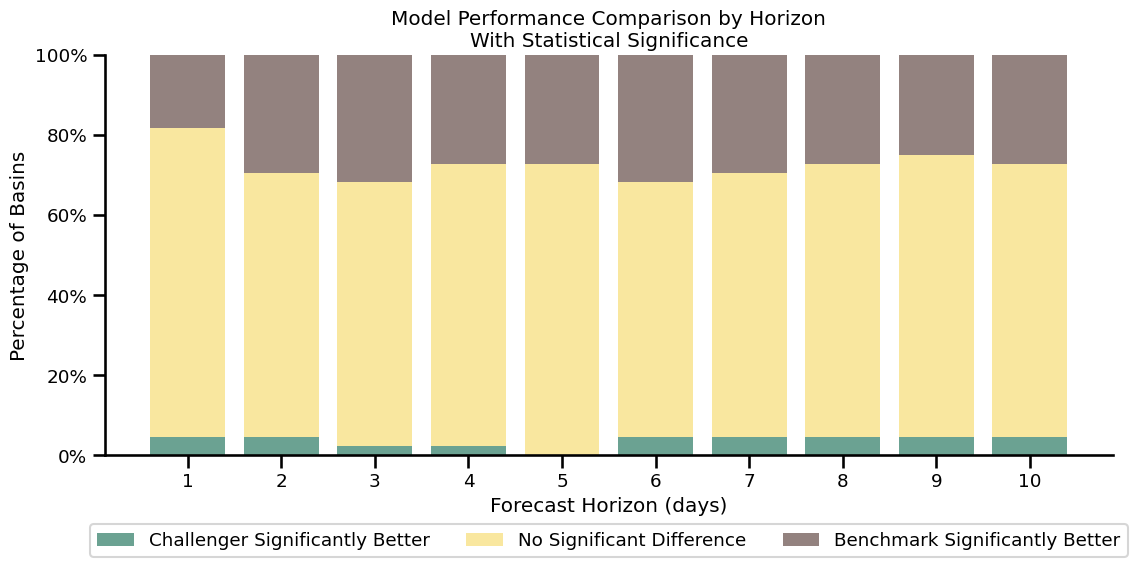

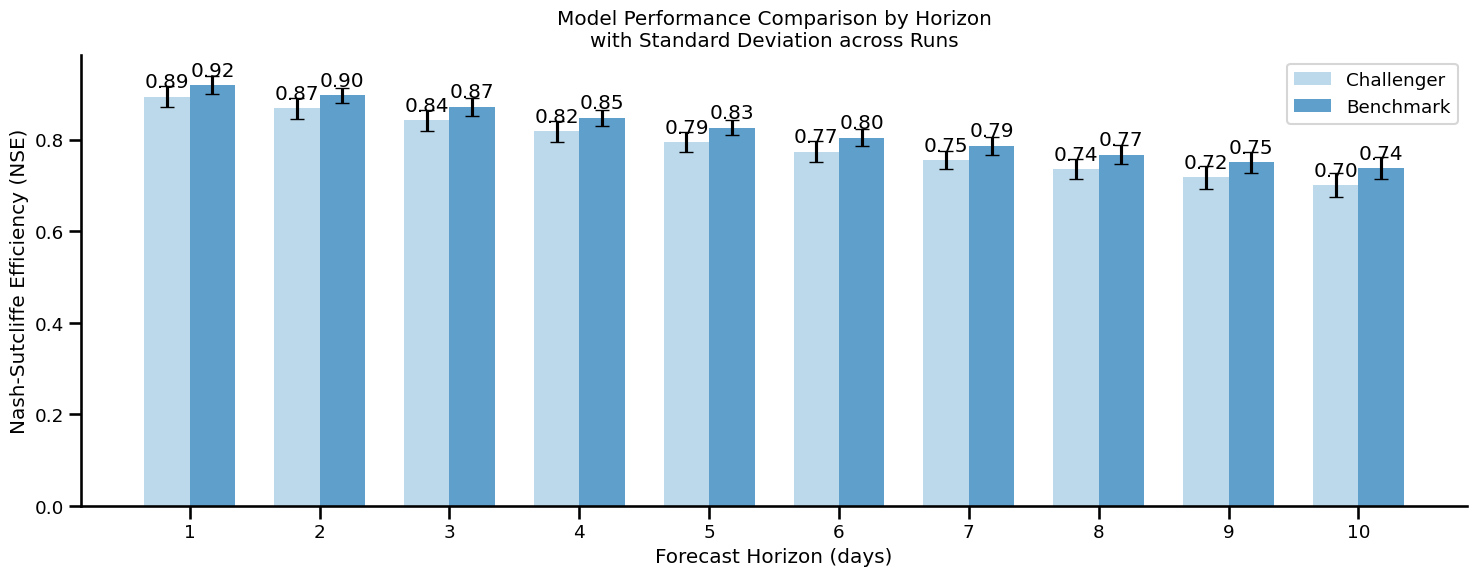


Performance Summary:
Average percentage where challenger significantly outperforms: 3.6%
Average percentage with no significant difference: 68.9%
Average percentage where benchmark significantly outperforms: 27.5%

Best horizon for challenger: 1 (4.5%)
Worst horizon for challenger: 5 (0.0%)

Mean NSE improvement across all horizons: -0.031


In [3]:
# Main execution
results_dir = "/Users/cooper/Desktop/CAMELS-CH/experiments/AdversarialDomainAdaptation/results"
num_runs = 5  # Update with your number of runs

# Load and process results
challenger_metrics_list, benchmark_metrics_list = load_experiment_results(
    results_dir, num_runs)

# Aggregate metrics across runs
challenger_agg = aggregate_metrics(challenger_metrics_list)
benchmark_agg = aggregate_metrics(benchmark_metrics_list)

# Calculate and visualize performance comparison
comparison_df = calculate_performance_comparison(challenger_agg, benchmark_agg)
plot_performance_comparison(comparison_df)
plot_nse_comparison(challenger_agg, benchmark_agg)
print_summary_statistics(comparison_df)

In [4]:
def analyze_performance_differences(
    challenger_df: pd.DataFrame,
    benchmark_df: pd.DataFrame,
    metric: str = "NSE"
) -> pd.DataFrame:
    """
    Analyze the magnitude of performance differences between challenger and benchmark models.

    Args:
        challenger_df: Aggregated metrics for challenger model
        benchmark_df: Aggregated metrics for benchmark model
        metric: Metric to analyze (default: NSE)

    Returns:
        DataFrame with analysis results per horizon
    """
    # Get unique horizons
    horizons = sorted(challenger_df["horizon"].unique())

    results = {
        "horizon": [],
        "num_better": [],
        "num_worse": [],
        "mean_improvement": [],
        "mean_degradation": [],
        "max_improvement": [],
        "max_degradation": [],
        "median_improvement": [],
        "median_degradation": [],
    }

    for horizon in horizons:
        # Filter data for current horizon
        challenger_horizon = challenger_df[challenger_df["horizon"] == horizon]
        benchmark_horizon = benchmark_df[benchmark_df["horizon"] == horizon]

        # Merge data
        comparison = pd.merge(
            challenger_horizon,
            benchmark_horizon,
            on=["basin_id", "horizon"],
            suffixes=("_challenger", "_benchmark")
        )

        # Calculate differences and statistical significance
        diff = comparison[f"{metric}_mean_challenger"] - \
            comparison[f"{metric}_mean_benchmark"]
        combined_std = np.sqrt(
            comparison[f"{metric}_std_challenger"]**2 +
            comparison[f"{metric}_std_benchmark"]**2
        )
        significant_threshold = 1.96 * combined_std  # 95% confidence interval

        # Identify significant improvements and degradations
        significant_better = diff > significant_threshold
        significant_worse = diff < -significant_threshold

        # Calculate statistics for improvements
        improvements = diff[significant_better]
        degradations = diff[significant_worse]

        results["horizon"].append(horizon)
        results["num_better"].append(len(improvements))
        results["num_worse"].append(len(degradations))
        results["mean_improvement"].append(
            improvements.mean() if len(improvements) > 0 else np.nan)
        results["mean_degradation"].append(
            degradations.mean() if len(degradations) > 0 else np.nan)
        results["max_improvement"].append(
            improvements.max() if len(improvements) > 0 else np.nan)
        results["max_degradation"].append(
            degradations.min() if len(degradations) > 0 else np.nan)
        results["median_improvement"].append(
            improvements.median() if len(improvements) > 0 else np.nan)
        results["median_degradation"].append(
            degradations.median() if len(degradations) > 0 else np.nan)

    return pd.DataFrame(results)


def print_detailed_analysis(analysis_df: pd.DataFrame) -> None:
    """Print detailed analysis of performance differences."""
    print("\nDetailed Performance Analysis:")
    print("=" * 80)

    # Overall statistics
    total_better = analysis_df["num_better"].sum()
    total_worse = analysis_df["num_worse"].sum()

    print(f"\nOverall Statistics:")
    print(f"Total cases of significant improvement: {total_better}")
    print(f"Total cases of significant degradation: {total_worse}")

    if total_better > 0:
        print(f"\nWhen Challenger Performs Better:")
        print(
            f"Average improvement in NSE: {analysis_df['mean_improvement'].mean():.3f}")
        print(
            f"Maximum improvement in NSE: {analysis_df['max_improvement'].max():.3f}")
        print(
            f"Median improvement in NSE: {analysis_df['median_improvement'].mean():.3f}")

    if total_worse > 0:
        print(f"\nWhen Challenger Performs Worse:")
        print(
            f"Average degradation in NSE: {analysis_df['mean_degradation'].mean():.3f}")
        print(
            f"Maximum degradation in NSE: {analysis_df['mean_degradation'].min():.3f}")
        print(
            f"Median degradation in NSE: {analysis_df['median_degradation'].mean():.3f}")

    print("\nBreakdown by Horizon:")
    print("-" * 80)
    for _, row in analysis_df.iterrows():
        print(f"\nHorizon {int(row['horizon'])}:")
        if row['num_better'] > 0:
            print(f"  Improvements ({row['num_better']} basins):")
            print(f"    Mean: {row['mean_improvement']:.3f}")
            print(f"    Median: {row['median_improvement']:.3f}")
            print(f"    Max: {row['max_improvement']:.3f}")
        if row['num_worse'] > 0:
            print(f"  Degradations ({row['num_worse']} basins):")
            print(f"    Mean: {row['mean_degradation']:.3f}")
            print(f"    Median: {row['median_degradation']:.3f}")
            print(f"    Max: {row['max_degradation']:.3f}")


def plot_performance_differences(analysis_df: pd.DataFrame) -> None:
    plt.figure(figsize=(12, 6))

    x = analysis_df['horizon'].values
    width = 0.35

    # Plot improvements and degradations
    plt.bar(x - width/2, analysis_df['median_improvement'],
            width, label='Significant Improvements', color='#6BA292')
    plt.bar(x + width/2, analysis_df['median_degradation'],
            width, label='Significant Degradations', color='#93827F')

    # Add reference line at y=0
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

    # Customize plot
    plt.xlabel('Forecast Horizon (days)')
    plt.ylabel('Median NSE Difference\n(Challenger - Benchmark)')
    plt.title('Median Performance Differences by Horizon')
    plt.legend()

    # Set x-axis ticks
    plt.xticks(x)

    plt.ylim(-0.1, 0.1)

    # Add grid
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Remove top and right spines
    sns.despine()

    plt.tight_layout()
    plt.show()


Detailed Performance Analysis:

Overall Statistics:
Total cases of significant improvement: 16
Total cases of significant degradation: 121

When Challenger Performs Better:
Average improvement in NSE: 0.101
Maximum improvement in NSE: 0.188
Median improvement in NSE: 0.101

When Challenger Performs Worse:
Average degradation in NSE: -0.112
Maximum degradation in NSE: -0.142
Median degradation in NSE: -0.070

Breakdown by Horizon:
--------------------------------------------------------------------------------

Horizon 1:
  Improvements (2.0 basins):
    Mean: 0.114
    Median: 0.114
    Max: 0.188
  Degradations (8.0 basins):
    Mean: -0.142
    Median: -0.081
    Max: -0.566

Horizon 2:
  Improvements (2.0 basins):
    Mean: 0.089
    Median: 0.089
    Max: 0.149
  Degradations (13.0 basins):
    Mean: -0.101
    Median: -0.062
    Max: -0.549

Horizon 3:
  Improvements (1.0 basins):
    Mean: 0.162
    Median: 0.162
    Max: 0.162
  Degradations (14.0 basins):
    Mean: -0.097
    

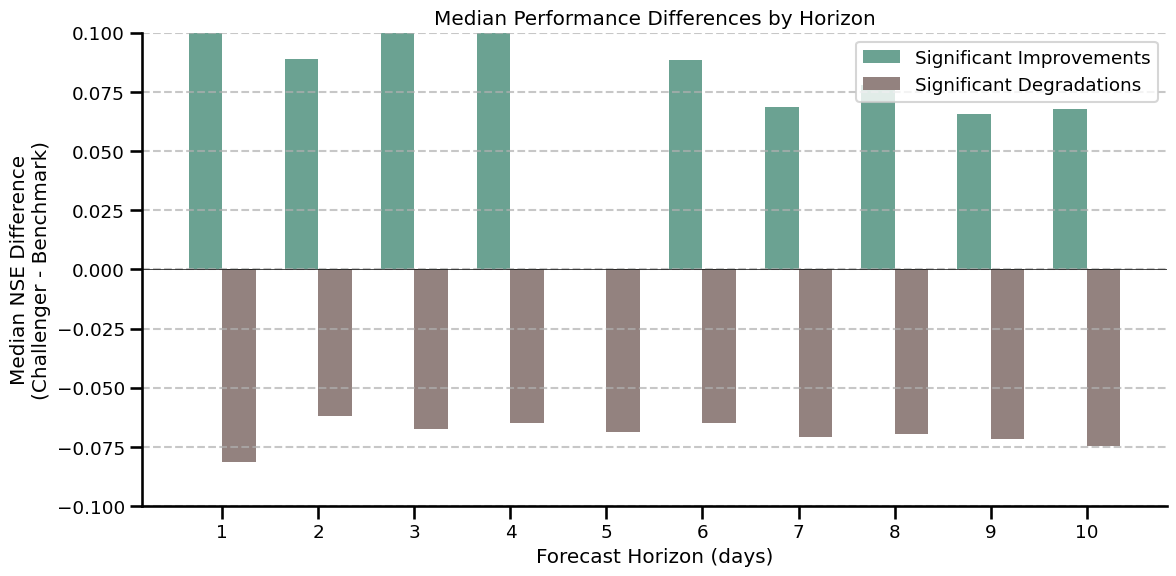

In [5]:
# Analyze performance differences
analysis_df = analyze_performance_differences(challenger_agg, benchmark_agg)
print_detailed_analysis(analysis_df)
plot_performance_differences(analysis_df)

In [6]:
def identify_basin_performance(
    challenger_df: pd.DataFrame,
    benchmark_df: pd.DataFrame,
    metric: str = "NSE"
) -> dict:
    """
    Identify basins where challenger significantly improves or degrades performance.
    
    Args:
        challenger_df: Aggregated metrics for challenger model
        benchmark_df: Aggregated metrics for benchmark model
        metric: Metric to analyze (default: NSE)
        
    Returns:
        Dictionary containing improved and degraded basins by horizon
    """
    # Get unique horizons
    horizons = sorted(challenger_df["horizon"].unique())
    
    results = {
        'improved': {h: [] for h in horizons},
        'degraded': {h: [] for h in horizons},
        'summary': {
            'consistently_improved': set(),
            'consistently_degraded': set(),
            'mixed_performance': set()
        }
    }
    
    # Track performance across all horizons
    all_improved_basins = set()
    all_degraded_basins = set()
    
    for horizon in horizons:
        # Filter data for current horizon
        challenger_horizon = challenger_df[challenger_df["horizon"] == horizon]
        benchmark_horizon = benchmark_df[benchmark_df["horizon"] == horizon]
        
        # Merge data
        comparison = pd.merge(
            challenger_horizon,
            benchmark_horizon,
            on=["basin_id", "horizon"],
            suffixes=("_challenger", "_benchmark")
        )
        
        # Calculate differences and statistical significance
        diff = comparison[f"{metric}_mean_challenger"] - comparison[f"{metric}_mean_benchmark"]
        combined_std = np.sqrt(
            comparison[f"{metric}_std_challenger"]**2 + 
            comparison[f"{metric}_std_benchmark"]**2
        )
        significant_threshold = 1.96 * combined_std  # 95% confidence interval
        
        # Identify basins with significant differences
        improved_mask = diff > significant_threshold
        degraded_mask = diff < -significant_threshold
        
        # Store basin IDs
        improved_basins = comparison.loc[improved_mask, "basin_id"].tolist()
        degraded_basins = comparison.loc[degraded_mask, "basin_id"].tolist()
        
        results['improved'][horizon] = improved_basins
        results['degraded'][horizon] = degraded_basins
        
        # Update sets of all improved/degraded basins
        all_improved_basins.update(improved_basins)
        all_degraded_basins.update(degraded_basins)
    
    # Identify basins that appear in both sets
    mixed_basins = all_improved_basins.intersection(all_degraded_basins)
    
    # Update summary
    results['summary']['consistently_improved'] = all_improved_basins - mixed_basins
    results['summary']['consistently_degraded'] = all_degraded_basins - mixed_basins
    results['summary']['mixed_performance'] = mixed_basins
    
    return results

def print_basin_analysis(results: dict) -> None:
    """Print analysis of basin performance."""
    print("\nBasin Performance Analysis:")
    print("=" * 80)
    
    print("\nConsistently Improved Basins:")
    print(f"Total: {len(results['summary']['consistently_improved'])}")
    print(sorted(results['summary']['consistently_improved']))
    
    print("\nConsistently Degraded Basins:")
    print(f"Total: {len(results['summary']['consistently_degraded'])}")
    print(sorted(results['summary']['consistently_degraded']))
    
    print("\nMixed Performance Basins:")
    print(f"Total: {len(results['summary']['mixed_performance'])}")
    print(sorted(results['summary']['mixed_performance']))
    
    print("\nBreakdown by Horizon:")
    print("-" * 80)
    for horizon in sorted(results['improved'].keys()):
        improved = results['improved'][horizon]
        degraded = results['degraded'][horizon]
        
        print(f"\nHorizon {horizon}:")
        print(f"  Improved ({len(improved)} basins):")
        print(f"    {sorted(improved)}")
        print(f"  Degraded ({len(degraded)} basins):")
        print(f"    {sorted(degraded)}")

In [7]:
# Identify basins with significant improvements/degradations
basin_results = identify_basin_performance(challenger_agg, benchmark_agg)
print_basin_analysis(basin_results)


Basin Performance Analysis:

Consistently Improved Basins:
Total: 4
['CA_15069', 'CA_15070', 'CA_17288', 'CA_17325']

Consistently Degraded Basins:
Total: 20
['CA_15020', 'CA_15022', 'CA_15025', 'CA_15039', 'CA_15081', 'CA_15090', 'CA_15214', 'CA_15216', 'CA_15259', 'CA_15285', 'CA_16055', 'CA_16068', 'CA_16070', 'CA_16136', 'CA_16153', 'CA_16158', 'CA_17050', 'CA_17100', 'CA_17338', 'CA_17462']

Mixed Performance Basins:
Total: 0
[]

Breakdown by Horizon:
--------------------------------------------------------------------------------

Horizon 1:
  Improved (2 basins):
    ['CA_15069', 'CA_15070']
  Degraded (8 basins):
    ['CA_15020', 'CA_15025', 'CA_15081', 'CA_15090', 'CA_16068', 'CA_16070', 'CA_16153', 'CA_17462']

Horizon 2:
  Improved (2 basins):
    ['CA_15069', 'CA_15070']
  Degraded (13 basins):
    ['CA_15020', 'CA_15025', 'CA_15081', 'CA_15090', 'CA_15214', 'CA_16068', 'CA_16070', 'CA_16153', 'CA_16158', 'CA_17050', 'CA_17100', 'CA_17338', 'CA_17462']

Horizon 3:
  Improv

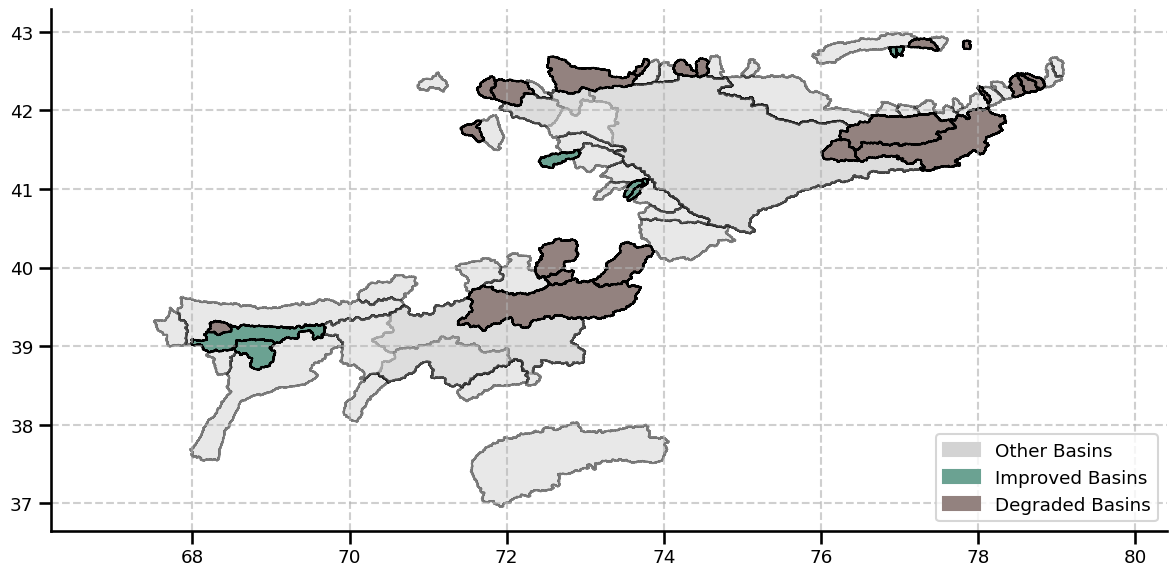

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Load and process the data
path_to_kgz_basins = "/Users/cooper/Desktop/CAMELS-CH/data/CA_raw/basin_outline/kyrgyzstan/HRU_KRG_ML_MODEL_BASINS_1d.shp"
path_to_tjik_basins = "/Users/cooper/Desktop/CAMELS-CH/data/CA_raw/basin_outline/tajikistan/HRU_TAJIK_ML_MODEL_BASINS_1d.shp"

kgz_basins = gpd.read_file(path_to_kgz_basins).to_crs(epsg=4326)
tjik_basins = gpd.read_file(path_to_tjik_basins).to_crs(epsg=4326)

# Define the basins of interest
improved_basins = ['CA_15069', 'CA_15070', 'CA_16134', 'CA_16135', 'CA_16151', 'CA_16160', 'CA_16161', 'CA_17150', 'CA_17325']

degraded_basins = ['CA_15020', 'CA_15022', 'CA_15025', 'CA_15039', 'CA_15081', 'CA_15090', 'CA_15194', 'CA_15214', 'CA_15216', 'CA_15259', 'CA_15285', 'CA_15287', 'CA_16055', 'CA_16068', 'CA_16070', 'CA_16136', 'CA_16153', 'CA_16158', 'CA_16159', 'CA_16176', 'CA_17100', 'CA_17338', 'CA_17462']


# Create masks for different basin categories
kgz_improved = kgz_basins['CODE'].astype(
    str).apply(lambda x: f'CA_{x}' in improved_basins)
kgz_degraded = kgz_basins['CODE'].astype(
    str).apply(lambda x: f'CA_{x}' in degraded_basins)
tjik_improved = tjik_basins['CODE'].astype(
    str).apply(lambda x: f'CA_{x}' in improved_basins)
tjik_degraded = tjik_basins['CODE'].astype(
    str).apply(lambda x: f'CA_{x}' in degraded_basins)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot regular basins
kgz_basins[~(kgz_improved | kgz_degraded)].plot(ax=ax, color='lightgrey',
                                                edgecolor='black', alpha=0.5)
tjik_basins[~(tjik_improved | tjik_degraded)].plot(
    ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

# Plot improved basins
kgz_basins[kgz_improved].plot(ax=ax, color='#6BA292', edgecolor='black')
tjik_basins[tjik_improved].plot(ax=ax, color='#6BA292', edgecolor='black')

# Plot degraded basins
kgz_basins[kgz_degraded].plot(ax=ax, color='#93827F', edgecolor='black')
tjik_basins[tjik_degraded].plot(ax=ax, color='#93827F', edgecolor='black')

# Manually add legend
legend_patches = [
    mpatches.Patch(color='lightgrey', label='Other Basins'),
    mpatches.Patch(color='#6BA292', label='Improved Basins'),
    mpatches.Patch(color='#93827F', label='Degraded Basins')
]

ax.legend(handles=legend_patches, loc="lower right")

# Customize the plot
plt.axis('equal')

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.6)

# Remove axis labels as they're not needed for a map
ax.set_xlabel('')
ax.set_ylabel('')

# Adjust layout to prevent legend cutoff
plt.tight_layout()
sns.despine()

plt.show()